## Example

In [27]:
import sys
sys.path.append("../")

from cv_expt.base.data.base_dataset import ImageDataset, ImageDataType
from cv_expt.base.defs.defs import ImageChannel, DataType
from cv_expt.base.logger.base_logger import BaseLogger, BaseLoggerConfig
from cv_expt.base.configs.configs import TrainerConfig, DataConfig
from cv_expt.vis.visualization import subplot_images
from cv_expt.base.logger.base_logger import BaseLogger
from cv_expt.base.models.base_model import ModelWrapper
from cv_expt.base.trainer.base_trainer import Trainer

from pathlib import Path
from typing import Optional
import torch
import cv2
import numpy as np
from tqdm import tqdm  # for progress bar
from torch import nn
from torch.optim import Optimizer
import segmentation_models_pytorch as smp
import datetime

def normalization(x):
    return x / 255.0

def denormalization(x):
    return x * 255.0

# random seed should be same for both
data_config = DataConfig(
    data_path=Path("../data/coco2017"),
    image_channels=ImageChannel.RGB,
    image_extensions=["jpg", "png"],
    max_data=-1,
    samples_per_epoch=2000,
)
val_data_config = DataConfig(
    data_path=Path("../data/coco2017"),
    image_channels=ImageChannel.RGB,
    image_extensions=["jpg", "png"],
    max_data=-1,
    samples_per_epoch=500,
)
train_dataset = ImageDataset(
    data_config,
    return_type=ImageDataType.TENSOR,
    normalization=normalization,
    denormalization=denormalization,
)
# data_config.samples_per_epoch = 100
val_dataset = ImageDataset(
    val_data_config,
    data_type=DataType.VALIDATION,
    return_type=ImageDataType.TENSOR,
    normalization=normalization,
    denormalization=denormalization,
)

config = TrainerConfig(
    result_dir=Path("../results"),
    expt_name="expt1",
    run_name=f"run_{datetime.datetime.now().date()}",
    epochs=100,
    show_images=True,
    batch_size=64,
    
)
model = smp.Unet("resnet18", classes=3, in_channels=1, activation="sigmoid")
model = ModelWrapper(
    model,
    postprocess=val_dataset.denormalization,
    preprocess=val_dataset.normalization,
)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
trainer = Trainer(
    model,
    config,
    optimizer,
    criterion,
    BaseLogger(BaseLoggerConfig(log_path=config.result_dir, name='gray2rgb', log_in_console=False)),
    train_dataset,
    val_dataset,
)
trainer.train()

Data type: DataType.TRAIN, Number of images: 131165, Data Length: 2000


## Inference on Some Unseen Images

In [23]:
loaded_model = torch.load("../results/expt1/run_2024-08-28/models/best_model.pth")
test_root = Path("../data/test_images")
# test_root = Path("../data/coco2017/train2017")
images = []
titles=[]
max_data = 5
for i, test_img in enumerate(test_root.iterdir()):
    if i >= max_data:
        break
    img = cv2.imread(str(test_img), cv2.IMREAD_GRAYSCALE )
    rgb_img = cv2.imread(str(test_img))
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
    images.append(rgb_img)
    images.append(img)
    img = cv2.resize(img, data_config.input_size[::-1])
    img = img / 255.0
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    # print(img.shape)
    pred = loaded_model(img.cuda())
    # print(pred.shape)
    pred = pred.squeeze(0)#.squeeze(0)
    pred = pred.detach().cpu().permute(1, 2, 0).numpy()
    # print(pred.shape)
    # print(pred.max(), pred.min())
    pred = (pred * 255).astype(np.uint8)
    images.append(pred)
    # print(pred.max(), pred.min())
    titles.extend(["RGB", "Gray", "Predicted RGB"])

/tmp/ipykernel_26188/319096866.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("../results/expt1/run_2024-08-28/models/best_model.pth")


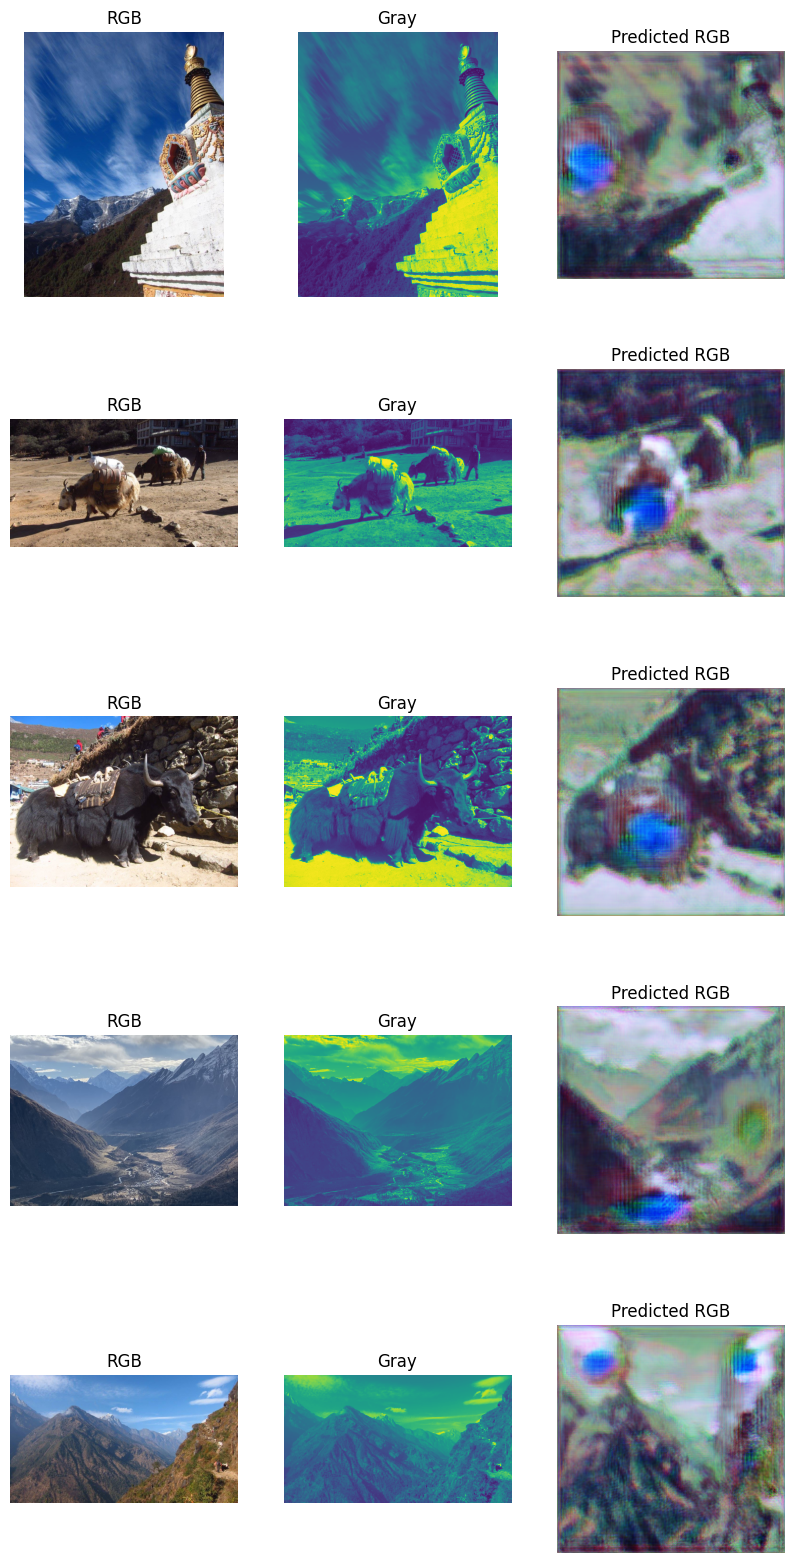

In [26]:
from cv_expt.vis.visualization import subplot_images
subplot_images(images, order=(-1, 3), titles=titles, fig_size=(10, 20)).savefig(str(trainer.images_dir/"test_images.png"))